# Maximum CDM values plotted against synaptic firing rates in the baseline model

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import LFPy
import synaptic_properties as sp
from lfpykit.models import CurrentDipoleMoment
from brainsignals.plotting_convention import simplify_axes, mark_subplots
from brainsignals import neural_simulations as ns
from figure_plots import amp_FT

from elephant.spike_train_generation import inhomogeneous_poisson_process
from quantities import Hz, ms
import neo

### Define parameters

In [2]:
np.random.seed(123)
dt = 2**-4
tstop = 400
num_tsteps = int(tstop / dt) + 1
tvec = np.arange(num_tsteps) * dt
freq = 20 # Hz
avrg_rate = 700 # Hz

# Synaptic rateprofiles
syn_rate_0 = sp.syn_rate(tvec, dt, freq, avrg_rate, phase=0)
syn_rate_pi = sp.syn_rate(tvec, dt, freq, avrg_rate, phase=np.pi)

### Simulate baseline neuron

In [3]:
cell = ns.return_hay_cell(tstop, dt, make_passive=False)
synidxs_ex = cell.get_rand_idx_area_norm(z_min=-200, z_max=100, nidx=100)
synidxs_in = cell.get_rand_idx_area_norm(z_min=-200, z_max=100, nidx=100)
del cell

def pz_amp(avrg_rate, i=None):

    cell = ns.return_hay_cell(tstop, dt, make_passive=False)

    # Define synapse parameters
    synapse_params_ex = sp.synapse_params(0)
    synapse_params_in = sp.synapse_params(-90)

    # Excitatory
    for synidx in synidxs_ex:
        synapse_params_ex["idx"] = synidx
        synapse = LFPy.Synapse(cell, **synapse_params_ex)
        spiketimes_rate = inhomogeneous_poisson_process(sp.syn_rate(tvec, dt, freq, avrg_rate, phase=0) * 1.2)
        synapse.set_spike_times(np.array(spiketimes_rate)*1000)

    # Inhibitory
    for s_, synidx in enumerate(synidxs_in):
        synapse_params_in["idx"] = synidx
        synapse = LFPy.Synapse(cell, **synapse_params_in)
        spiketimes_rate = inhomogeneous_poisson_process(sp.syn_rate(tvec, dt, freq, avrg_rate, phase=np.pi) * 1.2)
        synapse.set_spike_times(np.array(spiketimes_rate)*1000)

    cell.simulate(rec_imem=True, rec_vmem=True)
    cdms = CurrentDipoleMoment(cell).get_transformation_matrix() @ cell.imem

    cdms_FT = cdms[2, tvec>100]
    tvec_FT = tvec[tvec>100]

    cdms_freq, cdms_amp = amp_FT(tvec_FT, cdms_FT, freq)
    
    if i is not None:
        cm=1/2.54
        fig = plt.figure(figsize=(12*cm, 8*cm))
        fig.subplots_adjust(bottom=0.1, top=0.9, right=0.95, left=0.15, 
                            wspace=0.3, hspace=0.3,)
        cdm_act = fig.add_subplot(211, title=f'average rate: {avrg_rate}Hz\n', xlabel='time (ms)')
        mp_act = fig.add_subplot(212, xlabel='time (ms)')
        
        cdm_act.plot(tvec, cdms[2,:], label='current dipole moment (nA µm)', c='mediumpurple')
        # plt.title(f'average rate: {avrg_rate}Hz')
        mp_act.plot(tvec, cell.vmem[0, -len(tvec):], label='membrane potential (mV)', c='mediumaquamarine')
        cdm_act.legend()
        mp_act.legend()
        simplify_axes(fig.axes)
        mark_subplots([cdm_act, mp_act], "AB")
        plt.savefig(f'figures_active_cells/mp_cdm_individual_plot_1_{i+1}_1.pdf')
        plt.close("all")
    del cell
    del synapse
    
    return cdms_amp

### Run simulation using multiple firing rates

In [4]:
avrg_rate = np.arange(0, 1050, 50)
amp = [pz_amp(rate, i) for i, rate in enumerate(avrg_rate)]

Changing temperature 34.00 to 34.00
20.0 0.009740888969844229
Changing temperature 34.00 to 34.00
20.0 65.68244320275566
Changing temperature 34.00 to 34.00
20.0 93.57476197161257
Changing temperature 34.00 to 34.00
20.0 106.38351501700586
Changing temperature 34.00 to 34.00
20.0 109.88851276768665
Changing temperature 34.00 to 34.00
20.0 117.04667885639311
Changing temperature 34.00 to 34.00
20.0 124.41210151723911
Changing temperature 34.00 to 34.00
20.0 126.07396506622169
Changing temperature 34.00 to 34.00
20.0 128.09113376331672
Changing temperature 34.00 to 34.00
20.0 129.53851221383803
Changing temperature 34.00 to 34.00
20.0 129.738236530195
Changing temperature 34.00 to 34.00
20.0 132.6434586717924
Changing temperature 34.00 to 34.00
20.0 133.67236796616976
Changing temperature 34.00 to 34.00
20.0 132.57850279756647
Changing temperature 34.00 to 34.00
20.0 138.31253001118125
Changing temperature 34.00 to 34.00
20.0 133.79436597071063
Changing temperature 34.00 to 34.00
20.0 13

### Generating plot

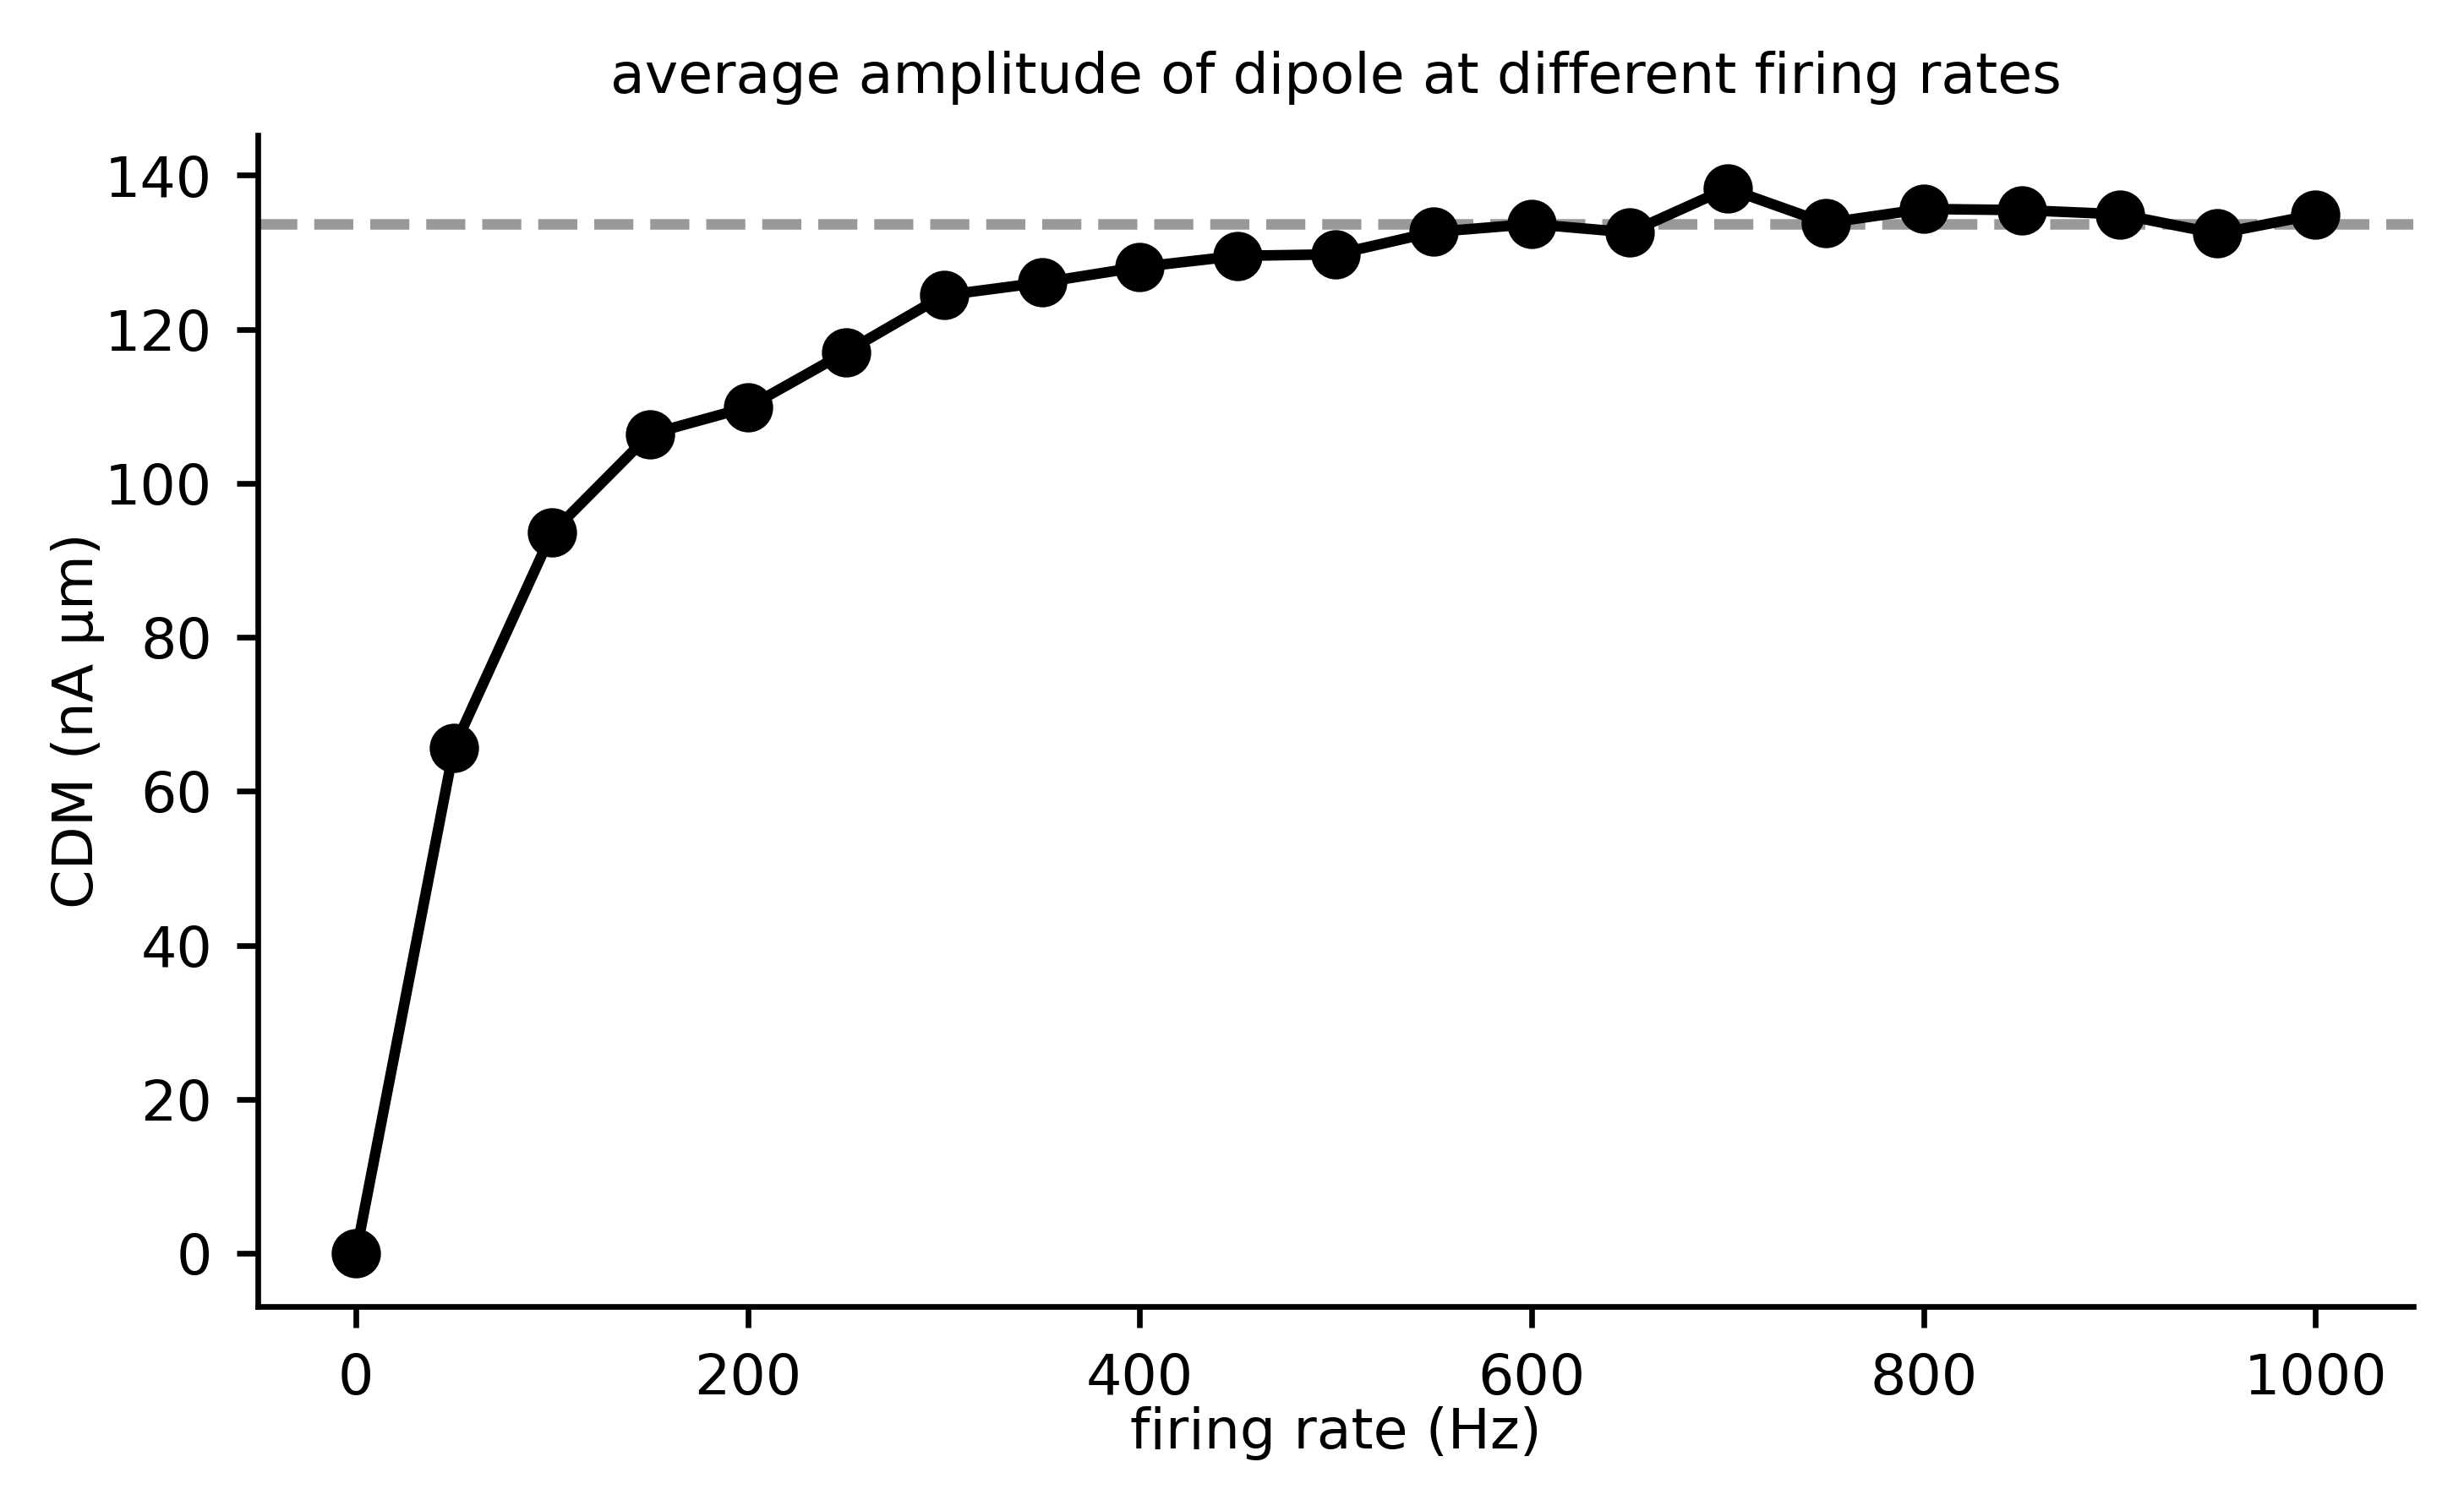

In [19]:
fig = plt.figure(figsize=(5,3))
fig.subplots_adjust(right=0.95)
avg_rate = fig.add_subplot(111)
avg_rate.axhline(np.mean(amp[list(avrg_rate).index(600)]), ls='--', c='gray', alpha=0.8)
avg_rate.plot(avrg_rate, amp, "-o", c='k')
plt.title("average amplitude of dipole at different firing rates")
plt.xlabel('firing rate (Hz)')
plt.ylabel('CDM (nA µm)')
simplify_axes(fig.axes)
plt.savefig('amp_CDM_baseline_model.pdf')